In [3]:
# load packages
import os
import csv

import numpy as np 
import pandas as pd 
import itertools
import re

import gensim
from gensim import models
from gensim import corpora
from gensim.utils import simple_preprocess
from collections import defaultdict

from nltk.stem import SnowballStemmer   
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [4]:
# set working directory
#os.chdir("/Users/deslava/Dropbox/deslava/BSE/text_mining/term_paper/")

In [5]:
# import pre-cleaned tweets data
data = pd.read_csv("data/all_english_tweets_preprocessed_v3.csv", lineterminator='\n') # .csv file
data["tokenized_text"] = data["tokenized_text"].fillna("[]").apply(lambda x: eval(x))

In [4]:
#data.T.iloc[:,2000:2005]

,2000,2001,2002,2003,2004
Unnamed: 0.1,2000,2001,2002,2003,2004
Unnamed: 0,365591,365596,365599,365600,365605
userid,1083595952,30122242,1266641338000424960,915351016366845952,3405435772
username,odwa_v,riwired,gunsnroses_x_,ProSportsExtra,mrtyrdmc_
acctdesc,Love❤. Respect🙏. Live👆,"Dogs, Theater, Music, Art, Dog Training, Peace...",🇵🇰,We cover the EXTRA news! The EXTRA content. Un...,☪️Küntü Kenz/Men Arefe/Bezmi Elest☪️\nİktisat ...
location,South Africa,Broadway,NaN,United States,"İstanbul, Türkiye"
following,1508,29366,123,578,269
followers,691,26722,142,20112,58
totaltweets,4172,483069,15142,31103,1114
usercreatedts,2013-01-12 17:23:19.000000,2009-04-10 01:35:01.000000,2020-05-30 08:03:31.000000,2017-10-03 23:01:03.000000,2015-08-06 09:05:04.000000


In [6]:
print(data.shape)
data = data[data['tokenized_text'].apply(lambda x: len(x) > 5)]
print(data.shape)

(2022257, 25)
(1780896, 25)


In [8]:
print(data.shape)

(1780896, 25)


In [6]:
line = 200001

print(data.iloc[line, 13])
print("\n")
print(data.iloc[line, 23])
print("\n")
print(data.iloc[line, 24])

Russian soldier sunbathing.

We need more of these going on Twitter. Retweet

Please like and retweet so these images can get to the real people of Russia, past #PutinHitler 

#DeadRussianSoldiers #Putler #PutinIsaWarCriminal #PutinHitler #Putin https://t.co/nmrQAMCST8


russian soldier sunbathing we need more of these going on twitter retweet please like and retweet so these images can get to the real people of russia past putinhitler deadrussiansoldiers putler putinisawarcriminal putinhitler putin


['soldier', 'sunbathing', 'need', 'going', 'twitter', 'retweet', 'please', 'like', 'retweet', 'images', 'get', 'real', 'people', 'past', 'putinhitler', 'deadrussiansoldiers', 'putler', 'putinisawarcriminal', 'putinhitler', 'putin']


## Tweet pooling

### a) No Pooling

In [7]:
texts_np = data['tokenized_text']
texts_np

1          [mp, sophia, fedyna, tells, ground, situation,...
2                 [cruise, missile, fired, army, fell, kiev]
4          [wrong, absolutely, wrong, joebiden, nato, un,...
5          [rd, mechanized, brigade, continues, suffer, l...
6          [world, must, act, immediately, stake, list, d...
                                 ...                        
2022252    [us, javelins, breaks, time, destroying, recor...
2022253    [rock, singer, chicherina, cuts, flag, energod...
2022254    [monday, march, confirmation, hearings, sc, no...
2022255    [four, years, actor, comedian, volodymyr, zele...
2022256    [volumes, hell, opened, inspection, place, put...
Name: tokenized_text, Length: 1780896, dtype: object

### b) Author-based pooling

In [8]:
texts_aut = data.groupby('userid')['tokenized_text'].apply(list).reset_index()
texts_aut['tokenized_text'] = [list(itertools.chain(*document)) for document in texts_aut['tokenized_text']]

texts_aut = texts_aut['tokenized_text']
texts_aut

0         [short, compilation, important, resources, inf...
1         [important, piece, safecast, azbyb, nuclear, p...
2         [woman, fled, russianinvasion, stands, near, f...
3         [woman, founder, building, product, women, nav...
4         [rt, mediagazer, media, regulator, warns, bloc...
                                ...                        
554014    [people, even, know, play, fair, want, see, eu...
554015    [ban, political, parties, ties, media, bias, d...
554016    [found, kit, let, find, idiot, vampirekillingk...
554017    [new, twitter, uploading, days, nft, earn, sen...
554018    [war, somebody, please, help, live, dont, cost...
Name: tokenized_text, Length: 554019, dtype: object

### c) Temporal pooling

In [9]:
texts_t = data.groupby(['timestamp', 'timestamp_H', 'timestamp_M'])['tokenized_text'].apply(list).reset_index()
texts_t['tokenized_text'] = [list(itertools.chain(*document)) for document in texts_t['tokenized_text']]

texts_t = texts_t['tokenized_text']
texts_t

0        [game, anonymous, cowards, running, show, behi...
1        [important, night, scum, going, around, houses...
2        [bomb, sucks, air, lungs, vicinity, powerful, ...
3        [u, swiss, impose, new, sanctions, u, announce...
4        [police, dergachi, kharkiv, region, east, capt...
                               ...                        
27742    [currently, taking, donations, aid, specifical...
27743    [several, western, capitals, advised, citizens...
27744    [nobody, win, send, guns, weak, people, solve,...
27745    [eucopresident, alexanderdecroo, andrzejduda, ...
27746    [ngin, president, ceo, fwalti, statement, situ...
Name: tokenized_text, Length: 27747, dtype: object

In [10]:
# define pooling method used
texts=texts_t

## Initial LDA analysis

In [11]:
#making bigrams and trigrams
bigram = gensim.models.Phrases(texts, min_count=1, threshold=1)
#trigram = gensim.models.Phrases(bigram[texts], threshold=1)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
#texts_trigrams = [trigram_mod[doc] for doc in texts]

In [12]:
#manual way of switching model is to comment out this line
texts = texts_bigrams

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
print(dictionary)

dictionary.filter_extremes(no_below = 500, no_above=0.8)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]

Dictionary(1130044 unique tokens: ['abandoned', 'abandoned_captured', 'abolishnato', 'absolutely_approve', 'abt']...)
Dictionary(3319 unique tokens: ['abandoned', 'across_world', 'actions', 'added', 'address']...)


In [13]:
#estimate the lda model
topicnumber=7

#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.1.
lda=models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber, 
                    alpha='auto', eta='auto', random_state=42)

lda.show_topics(topicnumber, 15)

[(0,
  '0.009*"us" + 0.009*"world" + 0.009*"kyiv" + 0.008*"people" + 0.008*"ukrainewar" + 0.006*"support" + 0.006*"country" + 0.005*"one" + 0.005*"like" + 0.005*"usa" + 0.005*"invasion" + 0.005*"today" + 0.004*"time" + 0.004*"help" + 0.004*"biden"'),
 (1,
  '0.012*"ukrainewar" + 0.010*"people" + 0.010*"new_nurembergtribunal" + 0.010*"passes_wages" + 0.010*"cronies_international" + 0.010*"urgent_call" + 0.010*"investigate_putin" + 0.009*"neighbour_join" + 0.009*"crime_aggression" + 0.009*"illegal_war" + 0.009*"every_day" + 0.009*"sign_rt" + 0.007*"world" + 0.007*"kyiv" + 0.007*"us"'),
 (2,
  '0.050*"nato_close" + 0.046*"sky_exclude" + 0.044*"un_security" + 0.037*"stop_aggression" + 0.027*"close_sky" + 0.025*"exclude_un" + 0.023*"aggression_nato" + 0.022*"security_council" + 0.021*"council" + 0.014*"europarl_en" + 0.009*"ua_parliament" + 0.009*"council_potus" + 0.009*"eucopresident_vonderleyen" + 0.009*"help_europe" + 0.007*"people"'),
 (3,
  '0.017*"people" + 0.010*"kyiv" + 0.009*"us" +

In [15]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis3 = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary=dictionary,sort_topics=False)#lda_model.id2word
vis3

C:\Users\icuev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.013497  0.007545       1        1  40.857214
1     -0.021915  0.015408       2        1   7.233110
2      0.155709 -0.001967       3        1   3.201167
3     -0.003855  0.007618       4        1  34.352873
4     -0.042091  0.027882       5        1  10.982576
5     -0.038203  0.045348       6        1   0.899910
6     -0.036148 -0.101834       7        1   2.473148, topic_info=            Term          Freq         Total Category  logprob  loglift
332       people  84652.000000  84652.000000  Default  30.0000  30.0000
442         stop  27619.000000  27619.000000  Default  29.0000  29.0000
301   nato_close  13629.000000  13629.000000  Default  28.0000  28.0000
506  un_security  13806.000000  13806.000000  Default  27.0000  27.0000
423  sky_exclude  11489.000000  11489.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
481        today    626.170829  36183.521409   Topic7  -5.6742  -0.3571
198         help    586.719683  30204.658372   Topic7  -5.7393  -0.2415
320          one    608.162862  35448.647847   Topic7  -5.7034  -0.3657
138       europe    543.125160  26832.681538   Topic7  -5.8165  -0.2004
226     invasion    548.070842  33635.813552   Topic7  -5.8074  -0.4173

[436 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3259      1  0.038959  action_world
3259      2  0.847361  action_world
3259      3  0.007792  action_world
3259      4  0.050647  action_world
3259      5  0.035063  action_world
...     ...       ...           ...
568       3  0.009597     zelenskyy
568       4  0.173106     zelenskyy
568       5  0.128200     zelenskyy
568       6  0.010050     zelenskyy
568       7  0.022182     zelenskyy

[1935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

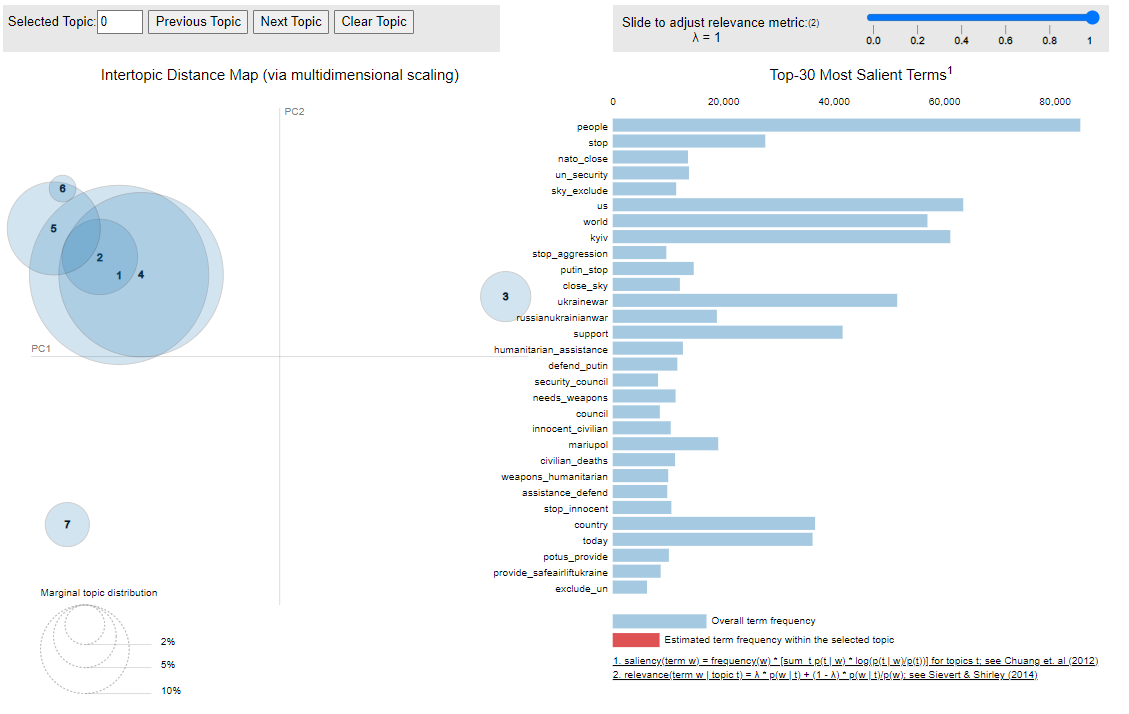

## Use Word2Vec to generate dictionary
We want to train our LDA on particular topics, namely:

+ Economic Sanctions
+ Geopolitics
+ Humanitarian Crisis (maybe split into two: Aid, Humanitarian Disaster)
+ Migration
+ Military operations
+ Casualties

We use Word2Vec to define a dictionary of words that we want to find in each topic, which we then feed into the LDA. The words used to train the Word2Vec are chosen by manually.

In [35]:
def tokenize(text):
    tokens = re.split(r'\W+', text)
    return tokens
corpus_data = data["cleaned_text"].astype(str).apply(tokenize)

In [36]:
corpus_data

1          [ukraine, mp, sophia, fedyna, tells, about, th...
2          [a, cruise, missile, fired, by, the, russian, ...
4          [now, this, is, wrong, absolutely, wrong, for,...
5          [rd, mechanized, brigade, continues, to, suffe...
6          [the, world, must, act, immediately, ukraine, ...
                                 ...                        
2022252    [us, javelins, breaks, the, all, time, destroy...
2022253    [russian, rock, singer, chicherina, cuts, ukra...
2022254    [monday, march, confirmation, hearings, for, s...
2022255    [for, four, years, the, actor, comedian, volod...
2022256    [when, the, volumes, of, hell, are, opened, fo...
Name: cleaned_text, Length: 1780896, dtype: object

In [37]:
corpus_list = corpus_data.tolist()
model = gensim.models.Word2Vec(corpus_list, min_count=10, vector_size=100)

In [38]:
print(np.asarray(model.wv.vectors).shape)

(69464, 100)


In [39]:
for index, word in enumerate(model.wv.index_to_key):
    if index == 30:
        break
    print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

word #0/69464 is the
word #1/69464 is ukraine
word #2/69464 is to
word #3/69464 is of
word #4/69464 is and
word #5/69464 is in
word #6/69464 is russia
word #7/69464 is a
word #8/69464 is is
word #9/69464 is putin
word #10/69464 is s
word #11/69464 is for
word #12/69464 is on
word #13/69464 is russian
word #14/69464 is are
word #15/69464 is war
word #16/69464 is you
word #17/69464 is it
word #18/69464 is this
word #19/69464 is with
word #20/69464 is that
word #21/69464 is from
word #22/69464 is i
word #23/69464 is we
word #24/69464 is will
word #25/69464 is be
word #26/69464 is not
word #27/69464 is nato
word #28/69464 is by
word #29/69464 is people


In [149]:
m = 25

In [150]:
# Geopolitics
geopolitics = model.predict_output_word(['international'], topn = m)

#print(model.predict_output_word(['nato'], topn = m))
#print(model.predict_output_word(['un'], topn = m))
#print(model.predict_output_word(['council'], topn = m))
print(model.predict_output_word(['international'], topn = m))

[('law', 0.8771703), ('community', 0.072264485), ('legion', 0.046703577), ('court', 0.0030120914), ('laws', 0.0003813333), ('relations', 9.809208e-05), ('affairs', 6.555795e-05), ('norms', 4.971539e-05), ('tribunal', 4.9541453e-05), ('committee', 4.5374774e-05), ('crime', 3.0492452e-05), ('refugeeconvention', 2.6510423e-05), ('pariah', 2.123886e-05), ('courts', 6.5404415e-06), ('organizations', 6.443323e-06), ('an', 6.363563e-06), ('fora', 5.908301e-06), ('conventions', 4.425159e-06), ('humanitarianorganizations', 3.94507e-06), ('forum', 3.6541578e-06), ('amnesty', 3.4360912e-06), ('disputes', 3.1245506e-06), ('violates', 2.507199e-06), ('arena', 2.4737699e-06), ('violation', 2.378214e-06)]


In [151]:
# Humanitarian Crisis
humanitarian = model.predict_output_word(['humanitarian'], topn = m)

print(model.predict_output_word(['humanitarian'], topn = m))

[('corridors', 0.9979617), ('corridor', 0.0019564992), ('assistance', 6.183002e-05), ('aid', 1.8828661e-05), ('catastrophe', 1.1476513e-06), ('crisis', 1.530333e-09), ('crises', 7.679382e-10), ('efforts', 6.574415e-10), ('cargo', 6.1375555e-10), ('airlift', 5.305243e-10), ('aide', 2.567658e-10), ('convoys', 8.582789e-11), ('purposes', 5.52272e-11), ('relief', 5.439754e-11), ('mission', 3.991219e-11), ('disaster', 3.4175975e-11), ('appeal', 2.6078379e-11), ('grounds', 1.655431e-11), ('humanitarianaid', 1.2582953e-11), ('access', 1.1741036e-11), ('blockade', 1.1089633e-11), ('passage', 1.0623167e-11), ('facilitate', 9.130939e-12), ('routes', 8.6651224e-12), ('convoy', 7.749276e-12)]


In [152]:
# Military operations
military = model.predict_output_word(['military'], topn = m)

print(model.predict_output_word(['military'], topn = m))
#print(model.predict_output_word(['attack'], topn = m))
#print(model.predict_output_word(['bombing'], topn = m))

[('equipment', 0.58267856), ('operation', 0.26813936), ('operations', 0.04088659), ('exercises', 0.023764659), ('hardware', 0.016709112), ('personnel', 0.015477413), ('bases', 0.011257191), ('installations', 0.01004014), ('vehicles', 0.0043930444), ('assistance', 0.0040322146), ('ops', 0.0031268022), ('targets', 0.0024938695), ('facilities', 0.0019148734), ('buildup', 0.0015244486), ('junta', 0.0010921769), ('capabilities', 0.0010920082), ('drills', 0.00078974146), ('base', 0.00078820426), ('aid', 0.0007391857), ('op', 0.00060249225), ('intervention', 0.00055674947), ('contractors', 0.0004735564), ('purposes', 0.0003401537), ('exercise', 0.00026705998), ('objects', 0.00022546363)]


In [153]:
'''
# Economic Sanctions

economics = model.predict_output_word(['economics'], topn = m)

print(model.predict_output_word(['economics'], topn = m))
#print(model.predict_output_word(['sanctions'], topn = m))
#print(model.predict_output_word(['business'], topn = m))
'''

"\n# Economic Sanctions\n\neconomics = model.predict_output_word(['economics'], topn = m)\n\nprint(model.predict_output_word(['economics'], topn = m))\n#print(model.predict_output_word(['sanctions'], topn = m))\n#print(model.predict_output_word(['business'], topn = m))\n"

In [154]:
'''
# Migration
migration = model.predict_output_word(['migration'], topn = m)

print(model.predict_output_word(['migration'], topn = m))
'''

"\n# Migration\nmigration = model.predict_output_word(['migration'], topn = m)\n\nprint(model.predict_output_word(['migration'], topn = m))\n"

In [155]:
#topics = [economics, geopolitics, humanitarian, migration, military]
topics = [geopolitics, humanitarian, military]

apriori = {}
n=1

for topic in topics:

    topic_list = []
    
    for word in topic:
        topic_list += [word[0]]
        
        apriori.update(dict(zip(topic_list, [n] * len(topic_list))))
        
    n += 1
        
print(apriori)

{'law': 1, 'community': 1, 'legion': 1, 'court': 1, 'laws': 1, 'relations': 1, 'affairs': 1, 'norms': 1, 'tribunal': 1, 'committee': 1, 'crime': 1, 'refugeeconvention': 1, 'pariah': 1, 'courts': 1, 'organizations': 1, 'an': 1, 'fora': 1, 'conventions': 1, 'humanitarianorganizations': 1, 'forum': 1, 'amnesty': 1, 'disputes': 1, 'violates': 1, 'arena': 1, 'violation': 1, 'corridors': 2, 'corridor': 2, 'assistance': 3, 'aid': 3, 'catastrophe': 2, 'crisis': 2, 'crises': 2, 'efforts': 2, 'cargo': 2, 'airlift': 2, 'aide': 2, 'convoys': 2, 'purposes': 3, 'relief': 2, 'mission': 2, 'disaster': 2, 'appeal': 2, 'grounds': 2, 'humanitarianaid': 2, 'access': 2, 'blockade': 2, 'passage': 2, 'facilitate': 2, 'routes': 2, 'convoy': 2, 'equipment': 3, 'operation': 3, 'operations': 3, 'exercises': 3, 'hardware': 3, 'personnel': 3, 'bases': 3, 'installations': 3, 'vehicles': 3, 'ops': 3, 'targets': 3, 'facilities': 3, 'buildup': 3, 'junta': 3, 'capabilities': 3, 'drills': 3, 'base': 3, 'op': 3, 'interve

## Apply topic dictionary to LDA

In [16]:
apriori={'law': 1, 'community': 1, 'legion': 1, 'court': 1, 'laws': 1, 'relations': 1, 'affairs': 1, 'norms': 1, 'tribunal': 1, 'committee': 1, 'crime': 1, 'refugeeconvention': 1, 'pariah': 1, 'courts': 1, 'organizations': 1, 'an': 1, 'fora': 1, 'conventions': 1, 'humanitarianorganizations': 1, 'forum': 1, 'amnesty': 1, 'disputes': 1, 'violates': 1, 'arena': 1, 'violation': 1, 'corridors': 2, 'corridor': 2, 'assistance': 3, 'aid': 3, 'catastrophe': 2, 'crisis': 2, 'crises': 2, 'efforts': 2, 'cargo': 2, 'airlift': 2, 'aide': 2, 'convoys': 2, 'purposes': 3, 'relief': 2, 'mission': 2, 'disaster': 2, 'appeal': 2, 'grounds': 2, 'humanitarianaid': 2, 'access': 2, 'blockade': 2, 'passage': 2, 'facilitate': 2, 'routes': 2, 'convoy': 2, 'equipment': 3, 'operation': 3, 'operations': 3, 'exercises': 3, 'hardware': 3, 'personnel': 3, 'bases': 3, 'installations': 3, 'vehicles': 3, 'ops': 3, 'targets': 3, 'facilities': 3, 'buildup': 3, 'junta': 3, 'capabilities': 3, 'drills': 3, 'base': 3, 'op': 3, 'intervention': 3, 'contractors': 3, 'exercise': 3, 'objects': 3}

C:\Users\icuev\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
topicnumber = 7

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=0.0001) # create a (ntopics, nterms) matrix and fill with low number
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index, term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 500  # put a large number in there
    return eta

C:\Users\icuev\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
eta = create_eta(apriori
                 , dictionary, topicnumber)
eta

C:\Users\icuev\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       ...,
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
       [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]])

In [19]:
#alpha default is ’symmetric’: Uses a fixed symmetric prior of 1.0 / num_topics. In our case that is 0.1.
lda2=models.LdaModel(corpus, id2word=dictionary, num_topics=topicnumber, 
                     random_state=42, alpha='auto', eta=eta)

lda2.print_topics(topicnumber, 15)

C:\Users\icuev\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.009*"us" + 0.009*"world" + 0.009*"kyiv" + 0.009*"people" + 0.008*"ukrainewar" + 0.006*"support" + 0.006*"country" + 0.005*"one" + 0.005*"like" + 0.005*"usa" + 0.005*"today" + 0.005*"invasion" + 0.004*"time" + 0.004*"help" + 0.004*"biden"'),
 (1,
  '0.015*"investigate_putin" + 0.014*"urgent_call" + 0.013*"crime_aggression" + 0.013*"sign_rt" + 0.013*"illegal_war" + 0.012*"every_day" + 0.011*"ukrainewar" + 0.010*"people" + 0.009*"kyiv" + 0.007*"world" + 0.007*"mariupol" + 0.007*"us" + 0.006*"today" + 0.005*"support" + 0.005*"country"'),
 (2,
  '0.059*"nato_close" + 0.053*"sky_exclude" + 0.048*"un_security" + 0.036*"stop_aggression" + 0.031*"close_sky" + 0.026*"exclude_un" + 0.023*"aggression_nato" + 0.021*"security_council" + 0.021*"council" + 0.018*"europarl_en" + 0.012*"ua_parliament" + 0.011*"council_potus" + 0.011*"eucopresident_vonderleyen" + 0.010*"help_europe" + 0.007*"eu_commission"'),
 (3,
  '0.017*"people" + 0.010*"kyiv" + 0.009*"us" + 0.007*"ukrainewar" + 0.006*"world

In [12]:
import pyLDAvis
import pyLDAvis.gensim_models

In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda2, corpus, dictionary=dictionary,sort_topics=False)#lda_model.id2word
vis

C:\Users\icuev\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\icuev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.040912  0.012762       1        1  47.320414
1      0.036058  0.025968       2        1   4.995829
2     -0.167354 -0.017578       3        1   2.927712
3      0.030080  0.012375       4        1  31.868432
4      0.049772  0.040257       5        1  10.133680
5     -0.051470  0.019400       6        1   0.804546
6      0.062002 -0.093184       7        1   1.949386, topic_info=            Term          Freq         Total Category  logprob  loglift
332       people  85230.000000  85230.000000  Default  30.0000  30.0000
442         stop  27187.000000  27187.000000  Default  29.0000  29.0000
301   nato_close  15359.000000  15359.000000  Default  28.0000  28.0000
506  un_security  15118.000000  15118.000000  Default  27.0000  27.0000
247         kyiv  61856.000000  61856.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
320          one    494.610856  35759.544925   Topic7  -5.6721  -0.3431
198         help    469.368225  30432.570291   Topic7  -5.7245  -0.2342
138       europe    434.947751  26940.201805   Topic7  -5.8006  -0.1885
226     invasion    434.786992  33968.284613   Topic7  -5.8010  -0.4207
397     russians    424.869783  25626.065252   Topic7  -5.8241  -0.1619

[450 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
878       1  0.276224     access
878       2  0.017163     access
878       3  0.377596     access
878       4  0.253161     access
878       5  0.070799     access
...     ...       ...        ...
568       3  0.007660  zelenskyy
568       4  0.154201  zelenskyy
568       5  0.118152  zelenskyy
568       6  0.005948  zelenskyy
568       7  0.018025  zelenskyy

[1895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

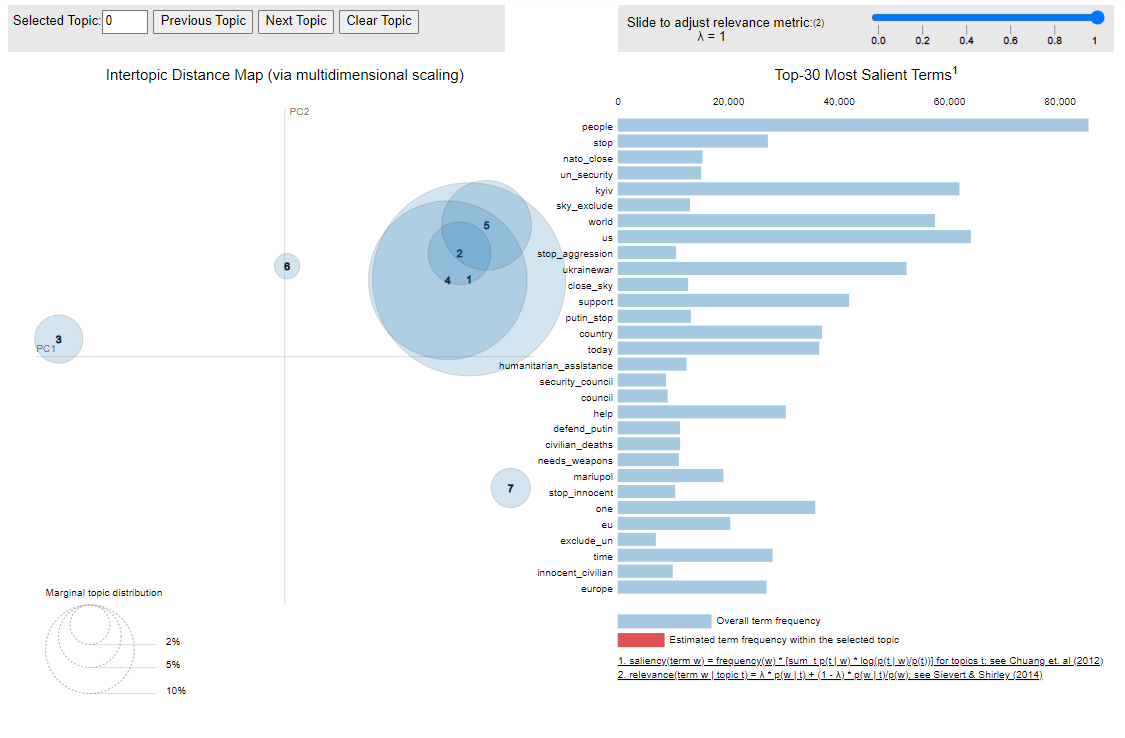